In [1]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import diffxpy.api as de
import time
from scipy import sparse

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
from importlib import reload  
import helper
reload(helper)
import helper as h
from constants import SAVE
import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr
#sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [4]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/nonref/'
UID2='STZ_nonref_annotation'

Load data:

In [5]:
#Load data
#adata=pickle.load(  open( shared_folder+"data_normalised.pkl", "rb" ) )
adata=h.open_h5ad(shared_folder+"data_normalised.h5ad",unique_id2=UID2)

## Add previously generated annotation

In [6]:
# Add previously generated annotation 
#adata_preannotated=h.open_h5ad("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/maren/data_endo_final.h5ad",unique_id2=UID2)
adata_preannotated=h.open_h5ad("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/subarna_study/GSE128565_adata_processed.h5ad.h5",unique_id2=UID2)

In [7]:
adata_preannotated

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb'
    obsm: 'X_umap'

In [8]:
# Subset preannotated dataset obs and order it to match current dataset
preannotated_obs=adata_preannotated.obs.copy()
preannotated_obs=preannotated_obs.reindex([idx.replace('-'+adata.obs.at[idx,'file'],'_'+adata.obs.at[idx,'file']) for idx in adata.obs.index])

In [9]:
# Add pre-prepared cell type annotation to currently used dataset
# Add 'pre_' before each original annotation
for annotation in ['groups_named_broad','groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata.obs[annotation_new]=preannotated_obs[annotation].values
    # Replace np.nan with na
    adata.obs[annotation_new] = adata.obs[annotation_new].cat.add_categories('NA')
    adata.obs[annotation_new].fillna('NA', inplace =True) 
    # Remove unused categories
    adata.obs[annotation_new].cat.remove_unused_categories(inplace=True)

Pre-annotated cell type count

In [10]:
# Count of cells per annotation
for annotation in ['groups_named_broad','groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst']:
    # For some reason the same line above does not remove all categories, thus it is done here again
    adata.obs['pre_'+annotation].cat.remove_unused_categories(inplace=True)
    print('pre_'+annotation,':')
    print(adata.obs['pre_'+annotation].value_counts())

pre_groups_named_broad :
NA              16002
beta             6631
polyhormonal     6021
delta            5621
alpha            5183
PP               1692
Name: pre_groups_named_broad, dtype: int64
pre_groups_named_fine :
NA                      16002
Sst-Ppy_low              5621
Gcg                      5183
Ins_dedifferentiated     4109
Ins-Sst-Ppy              2824
Ins_2                    2242
Ppy                      1692
Ins-Ppy                  1643
Gcg-Ppy_high              822
Gcg-Ppy_low               610
Ins_1                     280
Ins-Sst                   122
Name: pre_groups_named_fine, dtype: int64
pre_groups_named_beta_dpt :
NA                      16002
Sst-Ppy_low              5621
Gcg                      5183
Ins_dedifferentiated     4109
Ins-Sst-Ppy              2824
Ins_2                    2242
Ppy                      1692
Ins-Ppy                  1643
Gcg-Ppy_high              822
Gcg-Ppy_low               610
Ins_1                     166
Ins-Sst         

In [11]:
# Set one annotation column to pre_cell_type to enable below code to work
adata.obs.rename(columns={'pre_groups_named_beta_dpt':'pre_cell_type'}, inplace=True)

## Visualisation

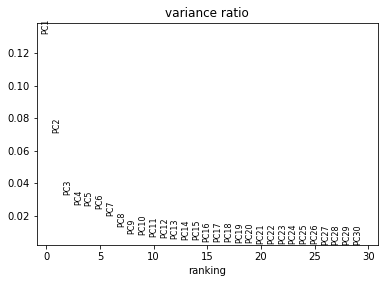

In [12]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [13]:
# Select number of PCs to use
N_PCS=15

Compare different embeddings based on previously defined annotation. 

In [14]:
#sc.pp.neighbors(adata,n_pcs = N_PCS,metric='correlation') 
#sc.tl.umap(adata)

In [15]:
#rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
#sc.pl.umap(adata,size=10,color=['file'])

In [16]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'

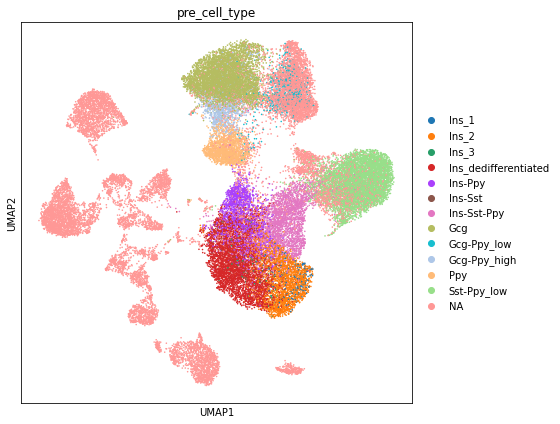

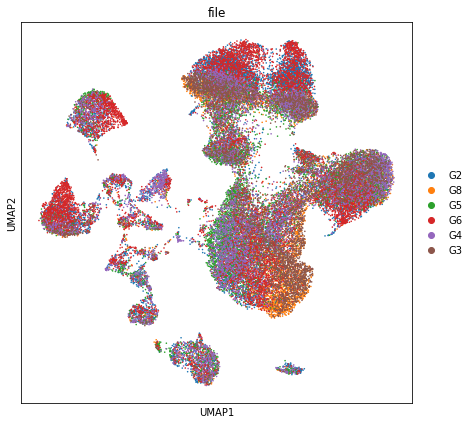

In [17]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata,size=10,color=['pre_cell_type'])
sc.pl.umap(adata,size=10,color=['file'])

#### On scaled data

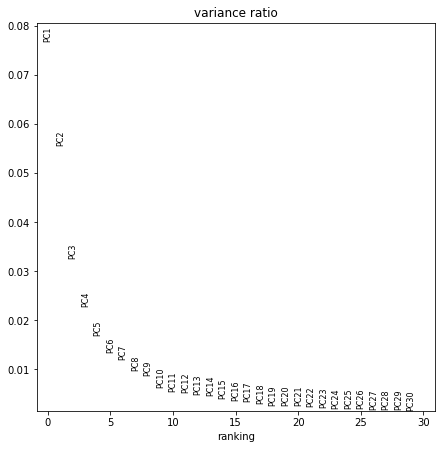

In [18]:
# Scale data and perform PCA
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_scl)

In [19]:
#C: Can not stay the same as above
N_PCS

15

In [20]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = 18) 

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [21]:
# Umap on scaled data
sc.tl.umap(adata_scl)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


In [22]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl']=adata_scl.obsm['X_umap']

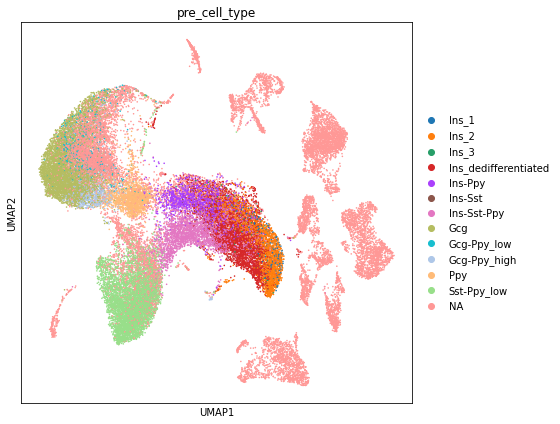

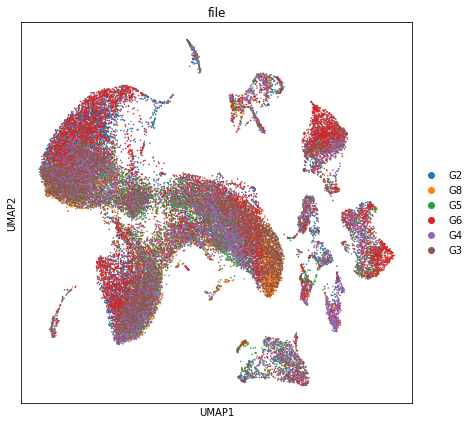

In [23]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_scl,size=10,color=['pre_cell_type'])
sc.pl.umap(adata_scl,size=10,color=['file'])

## Cell cycle
Performed separately for individual batches.

### Seurat/Scanpy - score by G2M and S

In [24]:
# Load mouse cell cycle genes
cell_cycle_mm=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/cell_cycle_mm_Macosko2015.tsv',sep='\t')

Use cell cycle genes that overlap HVGs (from different batches). Display these genes on HVG plots (with non-phase genes being marked as .NA).

Use G2/M and M gene sets for G2/M annotation and S gene set for S annotation.

G1/S N genes: 92 overlap var: 90 overlap hvg (all): 4
S N genes: 96 overlap var: 95 overlap hvg (all): 7
G2/M N genes: 127 overlap var: 126 overlap hvg (all): 16
M N genes: 143 overlap var: 141 overlap hvg (all): 13
M/G1 N genes: 108 overlap var: 105 overlap hvg (all): 5
N genes for scoring S: 7 and G2/M: 29


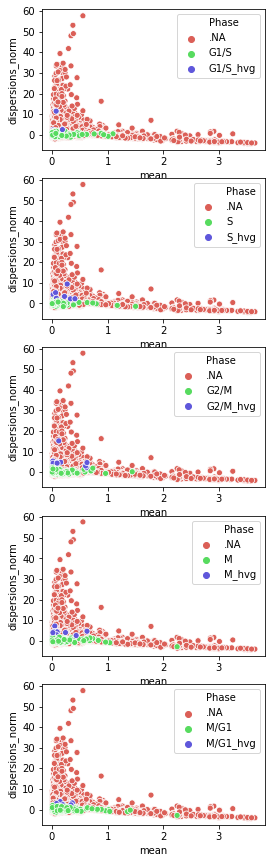

In [25]:
# How many of the cell cycle phase genes are present in HVG and in var and how variable they are
hvg=set(adata.var_names[adata.var.highly_variable])
i=0
rcParams['figure.figsize']=(4,15)
fig,axs=plt.subplots(5)
s_hvg=[]
g2m_hvg=[]
for phase in cell_cycle_mm.Phase.unique():
    genes_phase = set(cell_cycle_mm.query('Phase =="'+phase+'"').Gene)
    overlap_var = set(adata.var_names) & genes_phase
    overlap_hvg = hvg & genes_phase
    print(phase,'N genes:',len(genes_phase),'overlap var:',len(overlap_var),'overlap hvg (all):',len(overlap_hvg))
    phase_df=pd.DataFrame([phase]*len(overlap_var),index=overlap_var,columns=['Phase']).reindex(adata.var_names).fillna('.NA').sort_values('Phase')
    phase_df.loc[overlap_hvg,'Phase']=phase+'_hvg'
    phase_df['mean']=adata.var.means
    phase_df['dispersions_norm']=adata.var.dispersions_norm
    sb.scatterplot(x="mean", y="dispersions_norm", hue="Phase",data=phase_df,ax=axs[i],palette='hls')
    i+=1
    if phase == 'S':
        s_hvg.extend(overlap_hvg)
    if phase in ['G2/M','M']:
        g2m_hvg.extend(overlap_hvg)
        
print('N genes for scoring S:',len(s_hvg),'and G2/M:',len(g2m_hvg))

Cell cycle annotation

In [26]:
# Annotated cell cycle per batch
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes_cell_cycle(adata_tmp, s_genes=s_hvg, g2m_genes=g2m_hvg,use_raw=False)
    adata.obs.loc[idx,'S_score'] = adata_tmp.obs['S_score']
    adata.obs.loc[idx,'G2M_score'] = adata_tmp.obs['G2M_score']
    adata.obs.loc[idx,'phase'] = adata_tmp.obs['phase']
    
del adata_tmp

In [27]:
# Count of cells annotated to each phase
adata.obs['phase'].value_counts()

G1     20266
S      15974
G2M     4910
Name: phase, dtype: int64

Display cell cycle score distributions and annotation.

... storing 'phase' as categorical


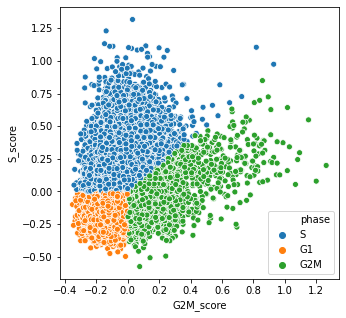

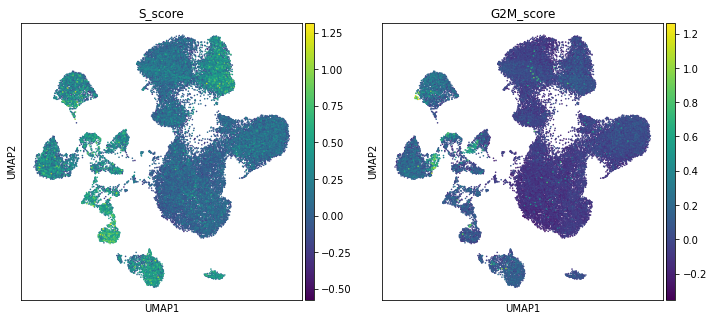

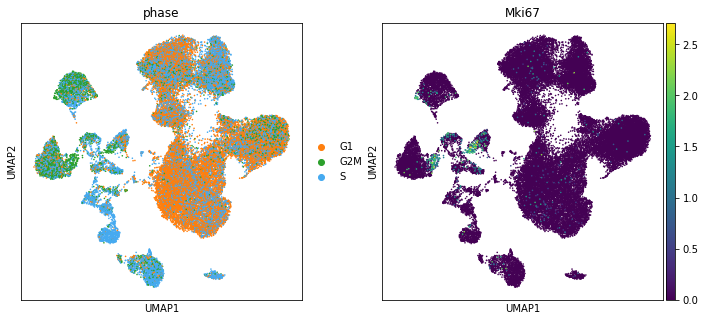

In [28]:
adata.uns['phase_colors']=['#ff7f0e', '#2ca02c','#46aaf0']

rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='G2M_score',y='S_score',hue='phase',data=adata.obs)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=10, use_raw=False)
sc.pl.umap(adata, color=['phase','Mki67'], size=10, use_raw=False)

#C: There might be some proliferating populations, but it is not very clear as many cells that probably are not proliferating (low Mki67 expression - not G2M) are annotated as cycling / G2M.

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [29]:
# Adata genes for R
genes=adata.var_names

#C: Current Ensembl release 101

In [30]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [31]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata.var_names))
adata.var['EID']=gene_ids.ensembl_gene_id

In [32]:
# Prepare R data for cyclonee
x_mat=adata.X.T
gene_ids=adata.var.EID
batches=adata.obs.file
cells=adata.obs.index

In [33]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "G2"
[1] "G8"
[1] "G5"
[1] "G6"
[1] "G4"
[1] "G3"


In [34]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1     40380
G2M      528
S        242
Name: phase_cyclone, dtype: int64

In [35]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata.obs.index)
adata.obs=pd.concat([adata.obs,cyclone_anno],axis=1)

... storing 'phase_cyclone' as categorical
... storing 'EID' as categorical


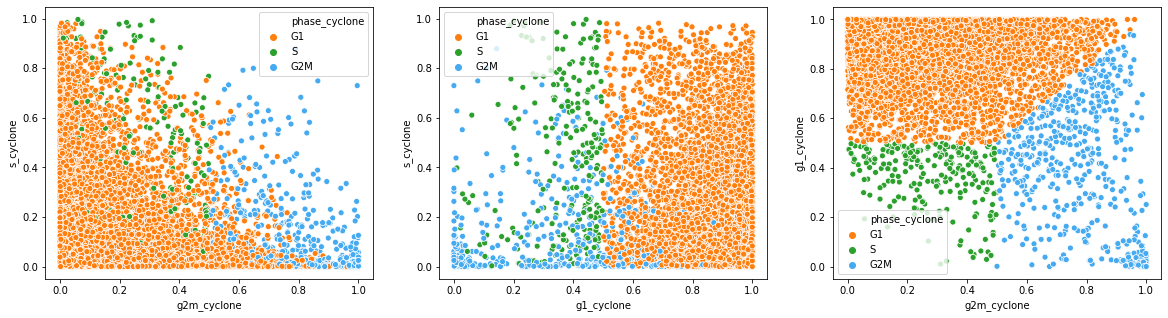

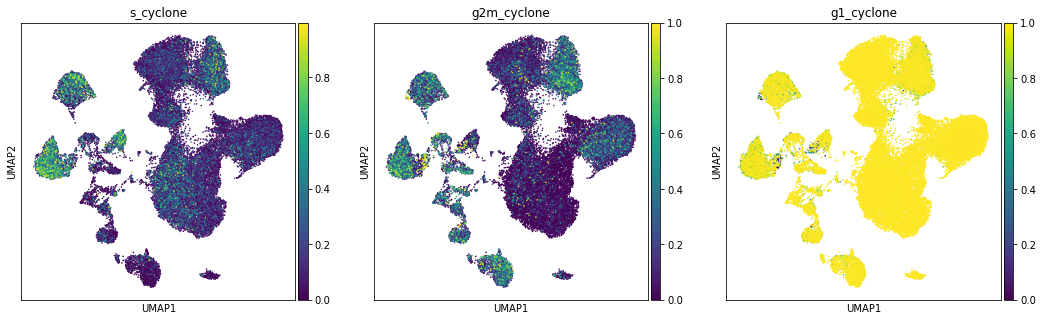

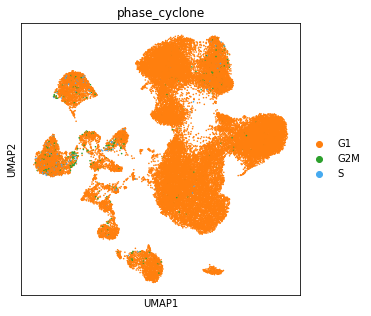

In [36]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors']=['#ff7f0e', '#2ca02c','#46aaf0']
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

#C: The cyclone results seem more reliable based on Mki67 expression (above) and embedding.

Check previous annotation results

In [37]:
for annotation in ['S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata.obs[annotation_new]=preannotated_obs[annotation].values
    # Replace np.nan with 'NA' if it is categorical
    if adata.obs[annotation_new].dtype.name=='category':
        adata.obs[annotation_new] = adata.obs[annotation_new].cat.add_categories('NA')
        adata.obs[annotation_new].fillna('NA', inplace =True) 
        # Remove unused categories
        adata.obs[annotation_new].cat.remove_unused_categories(inplace=True)

In [38]:
adata.obs.columns

Index(['file', 'n_counts', 'n_genes', 'mt_frac', 'n_genes_filter',
       'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors',
       'pre_groups_named_broad', 'pre_groups_named_fine', 'pre_cell_type',
       'pre_Ins-Gcg-Sst', 'S_score', 'G2M_score', 'phase', 'phase_cyclone',
       's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'pre_S_score',
       'pre_G2M_score', 'pre_phase', 'pre_proliferation',
       'pre_proliferation_man'],
      dtype='object')

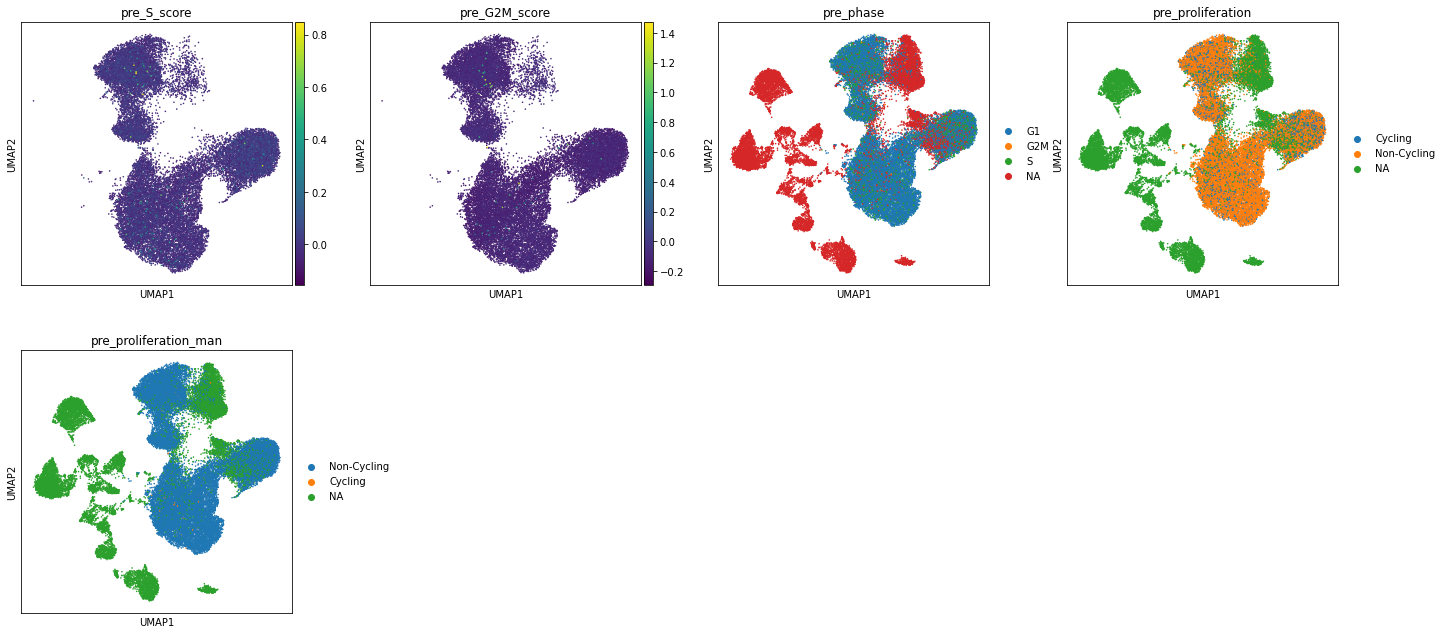

In [39]:
# Non-categorical variables do not show np.nan cells
sc.pl.umap(adata, color=['pre_S_score', 'pre_G2M_score', 'pre_phase',
       'pre_proliferation', 'pre_proliferation_man'], size=10, use_raw=False)

#C: cyclone annotation matches more previous manual (? - man?) annotation.

## Save intermediate results before cell type annotation

In [40]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)